In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Carregando seus dados
data = pd.read_csv('/content/sample_data/device_172383__variable_potencia__AirCompressior.csv')

# Supondo que você tenha 'value' como a coluna de interesse
data_test_array = data[['value']].to_numpy()



In [29]:
data

date      timestamp   value
0       2023-08-31 23:58:13-03:00  1693537093000  8089.0
1       2023-08-31 23:57:11-03:00  1693537031000  8129.0
2       2023-08-31 23:56:10-03:00  1693536970000  8143.0
3       2023-08-31 23:55:08-03:00  1693536908000  8140.0
4       2023-08-31 23:54:07-03:00  1693536847000  8171.0
...                           ...            ...     ...
130731  2023-04-30 00:04:27-03:00  1682823867000   206.0
130732  2023-04-30 00:03:26-03:00  1682823806000   206.0
130733  2023-04-30 00:02:24-03:00  1682823744000   206.0
130734  2023-04-30 00:01:23-03:00  1682823683000   206.0
130735  2023-04-30 00:00:21-03:00  1682823621000   206.0

[130736 rows x 3 columns]

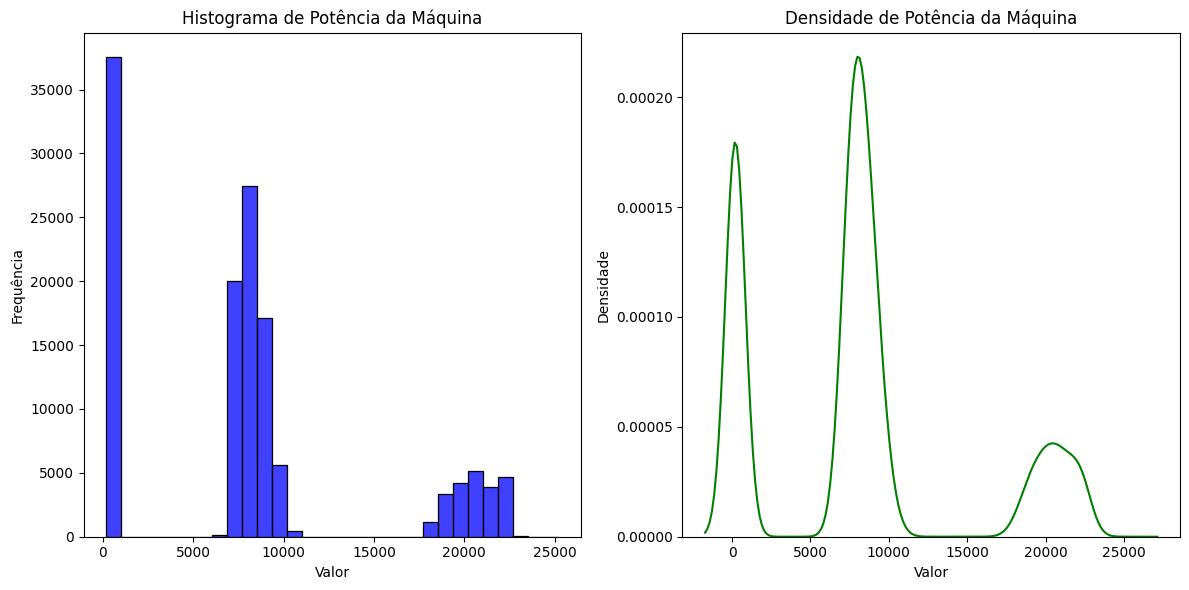

In [30]:
import seaborn as sns

# Iniciar a visualização do histograma
plt.figure(figsize=(12, 6))

# Histograma visualizar
plt.subplot(1, 2, 1)
sns.histplot(data['value'], kde=False, bins=30, color='blue')
plt.title('Histograma de Potência da Máquina')
plt.xlabel('Valor')
plt.ylabel('Frequência')

# Gráfico de Densidade Similar ao histograma mas visualizado em linha
plt.subplot(1, 2, 2)
sns.kdeplot(data['value'], color='green')
plt.title('Densidade de Potência da Máquina')
plt.xlabel('Valor')
plt.ylabel('Densidade')

plt.tight_layout()
plt.show()

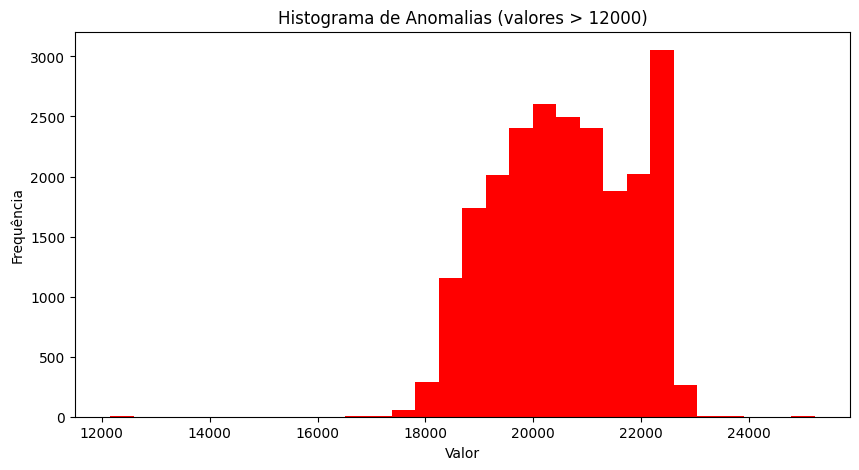

Número de anomalias detectadas: 22394


In [31]:
# Filtrando as anomalias pois o comportamento normal se limita até esse valor de 12000 Watts
anomalias = data[data['value'] > 12000]

# Visualizando as anomalias em um histograma
plt.figure(figsize=(10, 5))
plt.hist(anomalias['value'], bins=30, color='red')
plt.title('Histograma de Anomalias (valores > 12000)')
plt.xlabel('Valor')
plt.ylabel('Frequência')
plt.show()

# Mostrando o número de anomalias detectadas
print(f"Número de anomalias detectadas: {len(anomalias)}")

In [32]:
# Com o numero de anomalias detectadas eu posso agora criar um contexto para aprendizado de máquina
total_data_points = len(data)
number_of_outliers = len(anomalias)
contamination = number_of_outliers / total_data_points
contamination

0.17129176355403256

In [33]:
from sklearn.ensemble import IsolationForest

# Treinando o modelo Isolation Forest
model = IsolationForest(n_estimators=100, contamination = contamination, random_state=42)
model.fit(data[['value']])

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but IsolationForest was fitted with feature names



IsolationForest(contamination=0.17129176355403256, random_state=42)

In [34]:
# Utilizar o modelo para fazer a predição do valor
data['anomaly'] = model.predict(data[['value']])

# Convertendo para 0 = normal, 1 = anomalia
data['anomaly'] = data['anomaly'].map({1: 0, -1: 1})

# Verificando os resultados
print(data['anomaly'].value_counts())


anomaly
0    108366
1     22370
Name: count, dtype: int64


In [27]:
import plotly.graph_objects as go


# Para visualizar o que foi detectado como anomalia ou não, vou validar em forma gráfica e temporal
data['date'] = pd.to_datetime(data['date'])


# Usando PLotly para visualização
fig = go.Figure()

# Adicionando pontos para os dados
fig.add_trace(go.Scatter(
    x=data['date'],
    y=data['value'],
    mode='markers',
    marker=dict(
        color=data['anomaly'],  # Definindo a cor baseada na coluna 'anomaly'
        colorscale=['blue', 'red'],  # Normal em azul, Anomalias em vermelho
        size=5
    ),
    text='Valor: ' + data['value'].astype(str),
    customdata=data['anomaly'],
    hovertemplate=
        "<b>Date:</b> %{x|%Y-%m-%d %H:%M:%S}<br>" +  # Formatando a data no tooltip
        "<b>Valor:</b> %{text}<br>" +
        "<extra>Anomalia: %{customdata}</extra>",
    name='Dados'
))

# Configurações adicionais do gráfico
fig.update_layout(
    title='Anomalias Detectadas pelo Isolation Forest',
    xaxis_title='Data e Hora',
    yaxis_title='Valor de Potência Ativa Total',
    legend_title="Legenda",
    coloraxis_showscale=False,  # Desativa a legenda de cor
    xaxis=dict(
        type='date'  # Assegurando que o eixo x é tratado como data
    )
)

fig.show()